In [1]:
import networkx as nx
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib.collections as collections
import pandas as pd
import numpy as np

/home/jann/Desktop/repos/env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Reference: Xuezhi Liu Phd 2014 https://orca.cf.ac.uk/57830/1/2014LiuXPhD.pdf

## Input: Network graph topology and geographical coordinates

Load from file: 
* Edgelist
* Node attributes
    * Location
    * Node type

In [2]:
edge_list = pd.read_csv('data/edge_list.csv', header=0, index_col='pipe_no')
edge_list.head(2)

,from_node,to_node,lenght_m,diameter_mm,heat_transfer_coefficient_W/mK,roughness_mm
pipe_no,,,,,,
0,0,1,257.6,125,321.00,0.4
1,1,2,97.5,40,0.21,0.4


In [3]:
node_list = pd.read_csv('data/node_list.csv')
node_list.iloc[-2:]

,Unnamed: 0,node_id,lon,lat,node_type
31,31,31,12.381927,51.593706,producer
32,32,32,24.921000,60.164400,producer


In [4]:
def create_network(edge_list, node_list):
    """
    Create DHN from lists decribing edges and nodes
    
    """
    G = nx.MultiDiGraph()

    edge_attr = ['lenght_m', 'diameter_mm', 'heat_transfer_coefficient_W/mK', 'roughness_mm']
    G = nx.from_pandas_edgelist(edge_list, 'from_node', 'to_node', edge_attr=edge_attr, create_using=G)

    for node in G.nodes:
        G.add_node(node, lon=node_list.loc[int(node)]['lon'],
                         lat=node_list.loc[int(node)]['lat'],
                         node_type=node_list.loc[int(node)]['node_type'])

    return G


G = create_network(edge_list, node_list)

## Plotting

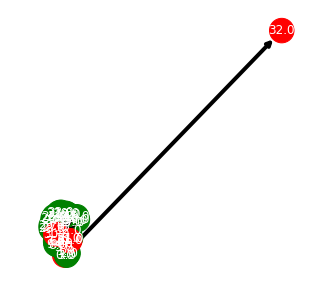

In [5]:
# https://networkx.github.io/documentation/stable/auto_examples/drawing/plot_directed.html

def draw_network(G, node_sizes, node_colors, edge_colors, edge_width):
    # pos = nx.circular_layout(G)
    # pos = nx.spring_layout(G)
    # pos = nx.fruchterman_reingold_layout(G.to_undirected())
    pos = {node_id: np.array([data['lon'], data['lat']]) for node_id, data in G.nodes(data=True)}
    fig = plt.figure(figsize=(5,5))
    nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors)
    labels = nx.draw_networkx_labels(G, pos, font_color='w')
    edges = nx.draw_networkx_edges(G, pos, node_size=node_sizes, arrowstyle='->',
                                   arrowsize=10, edge_color=edge_colors,
                                   edge_cmap=plt.cm.hot, width=edge_width)


    ax = plt.gca()
    ax.set_axis_off()
    plt.show()



# node_sizes = [600 + 10 * i for i in range(len(G))]
# M = G.number_of_edges()
# edge_colors = range(2, M + 2)
node_sizes = 600
node_color = {'producer': 'r',
              'consumer': 'g',
              'split': 'k'}

node_colors = [node_color[data['node_type']] for node_id, data in G.nodes(data=True)]
edge_colors = 'k'
# edge_alphas = [(5 + i) / (M + 4) for i in range(M)]

draw_network(G, node_sizes=node_sizes, node_colors=node_colors, edge_colors=edge_colors, edge_width=4)

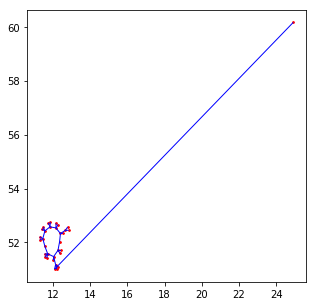

In [6]:
def draw_G(G, fig_width, fig_height, bgcolor='w',
               use_geom=False, edge_color='b', edge_linewidth=1,
               edge_alpha=1, node_size=3, node_color='r', node_alpha=1,
               node_edgecolor='r', node_zorder=1):

    fig, ax = plt.subplots(figsize=(fig_width, fig_height), facecolor=bgcolor)
    lines = []
    for u, v, data in G.edges(data=True):
        if 'geometry' in data and use_geom:
            # if it has a geometry attribute (a list of line segments), add them
            # to the list of lines to plot
            xs, ys = data['geometry'].xy
            lines.append(list(zip(xs, ys)))
        else:
            # if it doesn't have a geometry attribute, the edge is a straight
            # line from node to node
            x1 = G.nodes[u]['lon']
            y1 = G.nodes[u]['lat']
            x2 = G.nodes[v]['lon']
            y2 = G.nodes[v]['lat']
            line = [(x1, y1), (x2, y2)]
            lines.append(line)

    # add the lines to the axis as a linecollection
    lc = collections.LineCollection(lines, colors=edge_color, linewidths=edge_linewidth, alpha=edge_alpha, zorder=2)
    ax.add_collection(lc)

    node_Xs = [float(x) for _, x in G.nodes(data='lon')]
    node_Ys = [float(y) for _, y in G.nodes(data='lat')]
    ax.scatter(node_Xs, node_Ys, s=node_size, c=node_color, alpha=node_alpha, edgecolor=node_edgecolor, zorder=node_zorder)

    plt.show()

draw_G(G, 5, 5)

In [7]:
from shapely.geometry import Point
from shapely.geometry import LineString
import time
import geopandas as gpd
import math

## Project

In [8]:
def project_geometry(geometry, crs=None, to_crs=None, to_latlong=False):
    """
    Project a shapely Polygon or MultiPolygon from lat-long to UTM, or
    vice-versa
    Parameters
    ----------
    geometry : shapely Polygon or MultiPolygon
        the geometry to project
    crs : dict
        the starting coordinate reference system of the passed-in geometry,
        default value (None) will set settings.default_crs as the CRS
    to_crs : dict
        if not None, just project to this CRS instead of to UTM
    to_latlong : bool
        if True, project from crs to lat-long, if False, project from crs to
        local UTM zone
    Returns
    -------
    tuple
        (geometry_proj, crs), the projected shapely geometry and the crs of the
        projected geometry
    """

    if crs is None:
        crs = settings.default_crs

    gdf = gpd.GeoDataFrame()
    gdf.crs = crs
    gdf.gdf_name = 'geometry to project'
    gdf['geometry'] = None
    gdf.loc[0, 'geometry'] = geometry
    gdf_proj = project_gdf(gdf, to_crs=to_crs, to_latlong=to_latlong)
    geometry_proj = gdf_proj['geometry'].iloc[0]
    return geometry_proj, gdf_proj.crs


def project_gdf(gdf, to_crs=None, to_latlong=False):
    """
    Project a GeoDataFrame to the UTM zone appropriate for its geometries'
    centroid.
    The simple calculation in this function works well for most latitudes, but
    won't work for some far northern locations like Svalbard and parts of far
    northern Norway.
    Parameters
    ----------
    gdf : GeoDataFrame
        the gdf to be projected
    to_crs : dict
        if not None, just project to this CRS instead of to UTM
    to_latlong : bool
        if True, projects to latlong instead of to UTM
    Returns
    -------
    GeoDataFrame
    """
    assert len(gdf) > 0, 'You cannot project an empty GeoDataFrame.'
    start_time = time.time()

    # if gdf has no gdf_name attribute, create one now
    if not hasattr(gdf, 'gdf_name'):
        gdf.gdf_name = 'unnamed'

    # if to_crs was passed-in, use this value to project the gdf
    if to_crs is not None:
        projected_gdf = gdf.to_crs(to_crs)

    # if to_crs was not passed-in, calculate the centroid of the geometry to
    # determine UTM zone
    else:
        if to_latlong:
            # if to_latlong is True, project the gdf to latlong
            latlong_crs = settings.default_crs
            projected_gdf = gdf.to_crs(latlong_crs)
        else:
            # else, project the gdf to UTM
            # if GeoDataFrame is already in UTM, just return it
            if (gdf.crs is not None) and ('proj' in gdf.crs) and (gdf.crs['proj'] == 'utm'):
                return gdf

            # calculate the centroid of the union of all the geometries in the
            # GeoDataFrame
            avg_longitude = gdf['geometry'].unary_union.centroid.x

            # calculate the UTM zone from this avg longitude and define the UTM
            # CRS to project
            utm_zone = int(math.floor((avg_longitude + 180) / 6.) + 1)
            utm_crs = {'datum': 'WGS84',
                       'ellps': 'WGS84',
                       'proj' : 'utm',
                       'zone' : utm_zone,
                       'units': 'm'}
            print(utm_crs)
            # project the GeoDataFrame to the UTM CRS
            projected_gdf = gdf.to_crs(utm_crs)
            
    projected_gdf.gdf_name = gdf.gdf_name
    return projected_gdf


def project_graph(G, to_crs=None):
    """
    Project a graph from lat-long to the UTM zone appropriate for its geographic
    location.
    Parameters_
    ----------
    G : networkx multidigraph
        the networkx graph to be projected
    to_crs : dict
        if not None, just project to this CRS instead of to UTM
    Returns
    -------
    networkx multidigraph
    """

    G_proj = G.copy()

    # create a GeoDataFrame of the nodes, name it, convert osmid to str
    nodes = {node:data for node, data in G_proj.nodes(data=True)}
    gdf_nodes = gpd.GeoDataFrame(nodes).T
    gdf_nodes.crs = G_proj.graph['crs']
    gdf_nodes.gdf_name = '{}_nodes'.format(G_proj.name)
    # gdf_nodes['osmid'] = gdf_nodes['osmid'].astype(np.int64).map(make_str)

    # create a geometry column from x/y
    gdf_nodes['geometry'] = gdf_nodes.apply(lambda row: Point(row['lat'], row['lon']), axis=1)

    print('before', gdf_nodes['geometry'][-2:])
    print('before', gdf_nodes.crs)
    print('end before')
    # project the nodes GeoDataFrame to UTM
    gdf_nodes_utm = project_gdf(gdf_nodes, to_crs=to_crs)
    print('after', gdf_nodes_utm['geometry'][-2:])
    print('after', gdf_nodes_utm.crs)

    # extract data for all edges that have geometry attribute
    edges_with_geom = []
    for u, v, key, data in G_proj.edges(keys=True, data=True):
        if 'geometry' in data:
            edges_with_geom.append({'u':u, 'v':v, 'key':key, 'geometry':data['geometry']})

    # create an edges GeoDataFrame and project to UTM, if there were any edges
    # with a geometry attribute. geom attr only exists if graph has been
    # simplified, otherwise you don't have to project anything for the edges
    # because the nodes still contain all spatial data
    if len(edges_with_geom) > 0:
        gdf_edges = gpd.GeoDataFrame(edges_with_geom)
        gdf_edges.crs = G_proj.graph['crs']
        gdf_edges.gdf_name = '{}_edges'.format(G_proj.name)
        gdf_edges_utm = project_gdf(gdf_edges, to_crs=to_crs)

    # extract projected x and y values from the nodes' geometry column
    start_time = time.time()
    gdf_nodes_utm['x'] = gdf_nodes_utm['geometry'].map(lambda point: point.x)
    gdf_nodes_utm['y'] = gdf_nodes_utm['geometry'].map(lambda point: point.y)
    gdf_nodes_utm = gdf_nodes_utm.drop('geometry', axis=1)
 
    # clear the graph to make it a blank slate for the projected data
    start_time = time.time()
    edges = list(G_proj.edges(keys=True, data=True))
    graph_name = G_proj.graph['name']
    G_proj.clear()

    # add the projected nodes and all their attributes to the graph
    G_proj.add_nodes_from(gdf_nodes_utm.index)
    attributes = gdf_nodes_utm.to_dict()
    for label in gdf_nodes_utm.columns:
        nx.set_node_attributes(G_proj, name=label, values=attributes[label])

    # add the edges and all their attributes (including reconstructed geometry,
    # when it exists) to the graph
    for u, v, key, attributes in edges:
        if 'geometry' in attributes:
            row = gdf_edges_utm[(gdf_edges_utm['u']==u) & (gdf_edges_utm['v']==v) & (gdf_edges_utm['key']==key)]
            attributes['geometry'] = row['geometry'].iloc[0]

        # attributes dict contains key, so we don't need to explicitly pass it here
        G_proj.add_edge(u, v, **attributes)

    # set the graph's CRS attribute to the new, projected CRS and return the
    # projected graph
    G_proj.graph['crs'] = gdf_nodes_utm.crs
    G_proj.graph['name'] = '{}_UTM'.format(graph_name)
        
    return G_proj

In [9]:
G.graph = {'crs': {'init': 'epsg:4326'}, 'name': 'fictious_dhn'}

[node for node in G.nodes(data=True)][0]

(0.0,
 {'lon': 12.0856102005056, 'lat': 51.0053997797741, 'node_type': 'producer'})

3177642345    POINT (24.9278209 60.1677562)
3216400385    POINT (24.9340047 60.1675525)
Name: geometry, dtype: object
{'init': 'epsg:4326'}
{'datum': 'WGS84', 'ellps': 'WGS84', 'proj': 'utm', 'zone': 35, 'units': 'm'}
3177642345    POINT (385016.9685517756 6671898.076198913)
3216400385    POINT (385359.3161680779 6671864.645833493)
Name: geometry, dtype: object
{'datum': 'WGS84', 'ellps': 'WGS84', 'proj': 'utm', 'zone': 35, 'units': 'm'}
{'datum': 'WGS84', 'ellps': 'WGS84', 'proj': 'utm', 'zone': 35, 'units': 'm'}

In [10]:
to_crs = {'datum': 'WGS84',
          'ellps': 'WGS84',
          'proj' : 'utm',
          'zone' : 35,
          'units': 'm'}
G_proj = project_graph(G, to_crs=to_crs)

before 0.0      POINT (51.0053997797741 12.0856102005056)
1.0      POINT (51.1773061655202 12.1406966511578)
2.0       POINT (51.080855050392 12.2866874214735)
3.0                    POINT (51 12.2020098590675)
4.0     POINT (51.47293948449511 12.0351935191409)
5.0      POINT (51.3375543632386 12.0149067534391)
6.0      POINT (51.5792902489435 11.7138360338781)
7.0     POINT (51.56754326033339 11.5500478661088)
8.0     POINT (51.41918474155089 11.6739976667203)
9.0       POINT (51.458409251066 11.5690857058551)
10.0     POINT (51.7064159139175 12.2689922714874)
11.0      POINT (51.700982819565 12.4329752641306)
12.0     POINT (52.0160906925066 12.3535424427237)
13.0    POINT (52.33111061273171 12.4015974158254)
14.0     POINT (52.4445855568653 12.6592617477364)
15.0     POINT (52.5701701582133 12.7882423577706)
16.0    POINT (52.45193989830999 12.8375224266695)
17.0     POINT (52.3379226041572 12.5378645332127)
18.0     POINT (52.5380852925634 12.1579485462006)
19.0    POINT (52.661976

In [11]:
print(G.graph)
print(G_proj.graph)
G_proj.nodes(data=True)[32.0]

{'crs': {'init': 'epsg:4326'}, 'name': 'fictious_dhn'}
{'crs': {'datum': 'WGS84', 'ellps': 'WGS84', 'proj': 'utm', 'zone': 35, 'units': 'm'}, 'name': 'fictious_dhn_UTM'}


{'lat': 60.1644,
 'lon': 24.921,
 'node_type': 'producer',
 'x': 3972049.690238056,
 'y': 3214522.814511425}

POINT (384624.1787626689 6671539.986316172)  
{'init': 'epsg:4326'}  
{'datum': 'WGS84', 'ellps': 'WGS84', 'proj': 'utm', 'zone': 35, 'units': 'm'}

## Convert to geodataframe and save

In [12]:
node_gdf['geometry'] = node_gdf.apply(lambda row: Point(row['lat'], row['lon']), axis=1)
node_gdf.crs = {'init': 'epsg:4326'}
node_gdf[30:]

NameError: name 'node_gdf' is not defined

In [563]:
node_gdf.to_crs({'datum': 'WGS84', 'ellps': 'WGS84', 'proj': 'utm', 'zone': 35, 'units': 'm'})[30:]

,lat,lon,node_type,x,y,geometry
30.0,51.8583,11.5621,producer,593588,1.27827e+06,POINT (3292397.752857459 1405571.278393484)
31.0,51.5937,12.3819,producer,564539,1.36886e+06,POINT (3251483.417265969 1501525.805534149)
32.0,60.1644,24.921,producer,1.42793e+06,2.78765e+06,POINT (3972049.690238056 3214522.814511425)


In [562]:
nodes_proj['geometry'] = nodes_proj.apply(lambda row: Point(row['lon'], row['lat']), axis=1)
nodes_proj

,highway,lat,lon,osmid,x,y,geometry
25216594,NaN,24.9211,60.1648,25216594,384631,6.67158e+06,POINT (60.1647939 24.9210566)
25238874,NaN,24.921,60.1637,25238874,384626,6.67145e+06,POINT (60.1636645 24.9210282)
25238944,NaN,24.9213,60.1646,25238944,384643,6.67156e+06,POINT (60.164631 24.9212859)
25291537,NaN,24.937,60.1643,25291537,385516,6.6715e+06,POINT (60.1643249 24.9370245)
25291564,NaN,24.9417,60.1659,25291564,385779,6.67167e+06,POINT (60.1659489 24.9416784)
25291565,traffic_signals,24.9393,60.1651,25291565,385647,6.67159e+06,POINT (60.1651349 24.9393442)
25291591,NaN,24.9356,60.1654,25291591,385439,6.67162e+06,POINT (60.1653511 24.9355842)
25292473,NaN,24.9345,60.1634,25292473,385373,6.67141e+06,POINT (60.1634445 24.9345011)
25416262,NaN,24.9324,60.1711,25416262,385285,6.67227e+06,POINT (60.1711426 24.9324437)
25416263,NaN,24.9274,60.1694,25416263,384997,6.67208e+06,POINT (60.1694182 24.9273621)


In [561]:
nodes_proj.to_crs({'datum': 'WGS84', 'ellps': 'WGS84', 'proj': 'utm', 'zone': 35, 'units': 'm'}).head()

,highway,lat,lon,osmid,x,y,geometry
25216594,NaN,24.9211,60.1648,25216594,384631,6.67158e+06,POINT (3972091.962599523 3214541.969507125)
25238874,NaN,24.921,60.1637,25238874,384626,6.67145e+06,POINT (3971966.21444218 3214503.520448456)
25238944,NaN,24.9213,60.1646,25238944,384643,6.67156e+06,POINT (3972065.903613383 3214565.138737317)
25291537,NaN,24.937,60.1643,25291537,385516,6.6715e+06,POINT (3971497.257597838 3216491.922792146)
25291564,NaN,24.9417,60.1659,25291564,385779,6.67167e+06,POINT (3971521.366063667 3217114.733266024)


In [533]:
def graph_to_gdfs(G, nodes=True, edges=True, node_geometry=True, fill_edge_geometry=True):
    """
    Convert a graph into node and/or edge GeoDataFrames

    Parameters
    ----------
    G : networkx multidigraph
    nodes : bool
        if True, convert graph nodes to a GeoDataFrame and return it
    edges : bool
        if True, convert graph edges to a GeoDataFrame and return it
    node_geometry : bool
        if True, create a geometry column from node x and y data
    fill_edge_geometry : bool
        if True, fill in missing edge geometry fields using origin and
        destination nodes

    Returns
    -------
    GeoDataFrame or tuple
        gdf_nodes or gdf_edges or both as a tuple
    """

    if not (nodes or edges):
        raise ValueError('You must request nodes or edges, or both.')

    to_return = []

    if nodes:

        start_time = time.time()

        nodes = {node:data for node, data in G.nodes(data=True)}
        gdf_nodes = gpd.GeoDataFrame(nodes).T
        if node_geometry:
            gdf_nodes['geometry'] = gdf_nodes.apply(lambda row: Point(row['x'], row['y']), axis=1)
        gdf_nodes.crs = G.graph['crs']
        gdf_nodes.gdf_name = '{}_nodes'.format(G.graph['name'])

        to_return.append(gdf_nodes)
        
    if edges:

        start_time = time.time()

        # create a list to hold our edges, then loop through each edge in the
        # graph
        edges = []
        for u, v, data in G.edges(data=True):
            # for each edge, add key and all attributes in data dict to the
            # edge_details
            edge_details = {'u':u, 'v':v}
            for attr_key in data:
                edge_details[attr_key] = data[attr_key]

            # if edge doesn't already have a geometry attribute, create one now
            # if fill_edge_geometry==True
            if 'geometry' not in data:
                if fill_edge_geometry:
                    point_u = Point((G.nodes[u]['x'], G.nodes[u]['y']))
                    point_v = Point((G.nodes[v]['x'], G.nodes[v]['y']))
                    edge_details['geometry'] = LineString([point_u, point_v])
                else:
                    edge_details['geometry'] = np.nan

            edges.append(edge_details)

        # create a GeoDataFrame from the list of edges and set the CRS
        gdf_edges = gpd.GeoDataFrame(edges)
        gdf_edges.crs = G.graph['crs']
        gdf_edges.gdf_name = '{}_edges'.format(G.graph['name'])

        to_return.append(gdf_edges)
        
    if len(to_return) > 1:
        return tuple(to_return)
    else:
        return to_return[0]



In [534]:
node_gdf, edge_gdf = graph_to_gdfs(G_proj)

In [416]:
place_name_out = 'fictios_dhn'
nodes_out = r"shapefiles/%s_nodes.shp" % place_name_out
edges_out = r"shapefiles/%s_edges.shp" % place_name_out

invalid_cols = []
for col in invalid_cols:
    edge_gdf[col] = edge_gdf[col].astype(str)
node_gdf.to_file(edges_out)
edge_gdf.to_file(nodes_out)

/home/jann/Desktop/repos/env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
CPLE_NotSupported in Normalized/laundered field name: 'diameter_mm' to 'diameter_m'
CPLE_NotSupported in Normalized/laundered field name: 'heat_transfer_coefficient_W/mK' to 'heat_trans'
CPLE_NotSupported in Normalized/laundered field name: 'roughness_mm' to 'roughness_'


# Simulate district heating

## Known consumer flows without loops

In a radial network without loops, pressure does not have to be taken into account at all. The mass flows can be determined given the consumer flows and the continuity equation of flows.

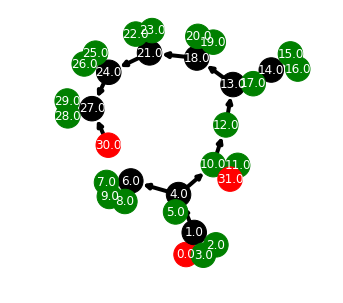

(32, 31)
(32,)
(array([-0.42449644, -0.24086459, -0.48857688,  0.36065385, -0.07416973,
        0.82272056, -0.56780289,  0.19242546,  0.10830539,  0.24929878,
       -0.40362482, -0.36706303, -0.28362468, -0.09066668, -0.14108668,
        0.13252172, -0.45180462,  0.43452708,  0.45173791, -0.16399157,
        0.32899874, -0.20457901,  0.28063505, -0.11435348,  0.28919995,
        0.24517937, -0.1793336 , -0.01759317,  0.09567095, -0.03926447,
       -0.02675104]), array([8.14733421]), 31, array([2.49082104, 2.47495261, 2.3753486 , 2.22442225, 2.18890106,
       2.17429798, 2.00779769, 1.84345312, 1.79079478, 1.73534673,
       1.25080036, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.85638731, 0.83107219, 0.76173537,
       0.66795276, 0.55223486, 0.50219054, 0.45685025, 0.32040024,
       0.17253841]))


/home/jann/Desktop/repos/env/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [573]:
edge_list = pd.read_csv('data/edge_list_tree_network.csv')
node_list = pd.read_csv('data/node_list_tree_network.csv')

G = create_network(edge_list, node_list)

node_sizes = 600
node_color = {'producer': 'r',
              'consumer': 'g',
              'split': 'k'}

node_colors = [node_color[data['node_type']] for node_id, data in G.nodes(data=True)]
edge_colors = 'k'
# edge_alphas = [(5 + i) / (M + 4) for i in range(M)]

draw_network(G, node_sizes=node_sizes, node_colors=node_colors, edge_colors=edge_colors, edge_width=4)

A = nx.incidence_matrix(G, oriented=True).todense()
number_nodes = len(G.nodes)
m = np.random.rand(number_nodes)
print(A.shape)
print(m.shape)
# np.linalg.det(A)
flows = np.linalg.lstsq(A, m)
print(flows)
#np.allclose(np.dot(A, flows), m)

In [10]:
def hydraulics_known_flows_wo_loops(G, m):
    A = nx.incidence_matrix(G, oriented=True).todense()
    m[0] = - 2*np.sum(m[1:])
    flows = np.linalg.lstsq(A,m)[0]
    return flows
    
node_data = G.nodes(data=True)
node_data = pd.DataFrame([data for node_id, data in G.nodes(data=True)])
node_data.index.names = ['node_id']

In [11]:
number_nodes = len(G.nodes)
m = np.random.rand(number_nodes)
m[node_data['node_type'] == 'split'] = 0
print('m', m)
flows = hydraulics_known_flows_wo_loops(G, m) 
print('flows', flows)

m [0.23349158 0.         0.83682982 0.55279085 0.         0.37168052
 0.         0.46174478 0.62129106 0.42751245 0.75561428 0.49145198
 0.51994935 0.         0.         0.90742937 0.76497689 0.42750551
 0.         0.34403742 0.04701765 0.         0.17501259 0.82042045
 0.         0.06072866 0.60248999 0.         0.82858965 0.7368124
 0.63462285 0.4857997 ]
flows [23.37754432  1.20790195  0.92386298 20.87470726  0.74275265  2.99483682
 16.76604565  0.83281691  0.99236319  0.79858458  0.86252411 13.9199633
 13.02894182  2.78562266  0.79857764  9.07366938  1.27850151  1.13604902
  0.71510956  0.41808978  7.56939792  0.54608472  1.19149258  5.46074848
  0.43180079  0.97356212  3.68431343  1.19966178  1.10788454 -1.00569498
 -0.85687183]


/home/jann/Desktop/repos/env/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


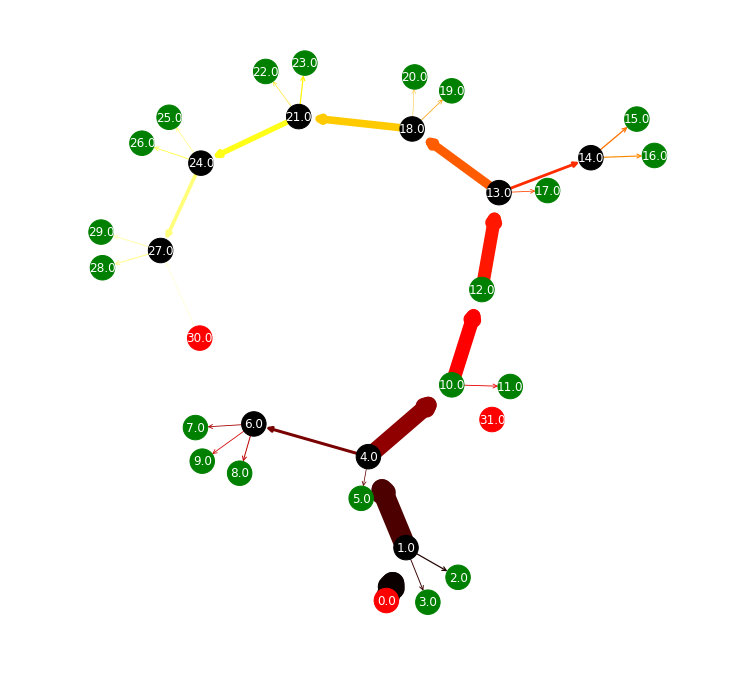

In [12]:
# Need to create a layout when doing
# separate calls to draw nodes and edges
M = G.number_of_edges()
edge_colors = range(2, M + 2)
draw_network(G, node_sizes=node_sizes, node_colors=node_colors,
             edge_colors=edge_colors, edge_width=abs(flows))

## Known consumer flows with loops

In the case of meshed networks, the number of unknown flows is larger than the number of independent flow continuity equations.

In [13]:
def hydraulics_known_flows_with_loops():
    pass
    

## Unknown consumer flows

## Excursion to street networks

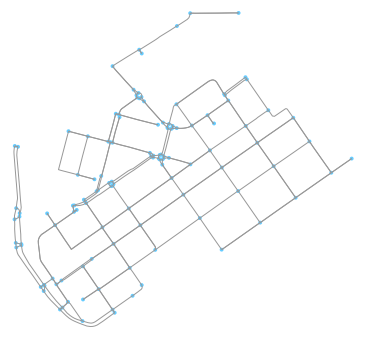

In [463]:
import osmnx as ox
import geopandas as gpd

place_name = "Kamppi, Helsinki, Finland"
graph = ox.graph_from_place(place_name, network_type='drive')
fig, ax = ox.plot_graph(graph)


In [69]:
for u, v, data in graph.edges(keys=False, data=True):
    print(data)
    print(v)

{'osmid': 23856784, 'oneway': True, 'lanes': '2', 'name': 'Mechelininkatu', 'highway': 'primary', 'maxspeed': '40', 'length': 40.885, 'geometry': <shapely.geometry.linestring.LineString object at 0x7f82db106e48>}
1372425714
{'osmid': [29977177, 30470347], 'oneway': True, 'lanes': '3', 'name': 'Mechelininkatu', 'highway': 'primary', 'maxspeed': '40', 'length': 16.601, 'geometry': <shapely.geometry.linestring.LineString object at 0x7f82db0ae358>}
1372425713
{'osmid': [372440330, 8135861], 'oneway': True, 'lanes': '2', 'highway': 'primary', 'maxspeed': '40', 'length': 25.167000000000005, 'geometry': <shapely.geometry.linestring.LineString object at 0x7f82db0ae668>}
25216594
{'osmid': [25514547, 30288797, 30288799], 'oneway': True, 'lanes': '2', 'name': 'Mechelininkatu', 'highway': 'primary', 'maxspeed': '40', 'length': 242.477, 'geometry': <shapely.geometry.linestring.LineString object at 0x7f82db0ae208>}
319896278
{'osmid': [30568275, 36729015, 316590744, 316590745, 316590746], 'oneway':

In [464]:
# https://networkx.github.io/documentation/stable/reference/classes/generated/networkx.MultiDiGraph.edges.html
for i in graph.nodes(data=True):
    print(i, '\n')

(25216594, {'y': 60.1647939, 'x': 24.9210566, 'osmid': 25216594}) 

(25238874, {'y': 60.1636645, 'x': 24.9210282, 'osmid': 25238874}) 

(25238944, {'y': 60.164631, 'x': 24.9212859, 'osmid': 25238944}) 

(25291537, {'y': 60.1643249, 'x': 24.9370245, 'osmid': 25291537}) 

(25291564, {'y': 60.1659489, 'x': 24.9416784, 'osmid': 25291564}) 

(25291565, {'y': 60.1651349, 'x': 24.9393442, 'osmid': 25291565, 'highway': 'traffic_signals'}) 

(25291591, {'y': 60.1653511, 'x': 24.9355842, 'osmid': 25291591}) 

(25292473, {'y': 60.1634445, 'x': 24.9345011, 'osmid': 25292473}) 

(25416262, {'y': 60.1711426, 'x': 24.9324437, 'osmid': 25416262}) 

(25416263, {'y': 60.1694182, 'x': 24.9273621, 'osmid': 25416263}) 

(25416267, {'y': 60.1707248, 'x': 24.9315761, 'osmid': 25416267}) 

(56113314, {'y': 60.1664918, 'x': 24.9306927, 'osmid': 56113314}) 

(56115897, {'y': 60.1669433, 'x': 24.9272229, 'osmid': 56115897, 'highway': 'traffic_signals'}) 

(56116937, {'y': 60.1641708, 'x': 24.9266982, 'osmid': 56

In [477]:
for a, b in graph.nodes(data=True):
    b['lon'] = b['y']
    b['lat'] = b['x']
graph.graph

{'name': 'Kamppi, Helsinki, Finland',
 'crs': {'init': 'epsg:4326'},
 'simplified': True,
 'streets_per_node': {25216594: 4,
  25238874: 4,
  25238944: 3,
  25291537: 4,
  25291564: 4,
  25291565: 4,
  25291591: 4,
  25292473: 4,
  25416262: 4,
  25416263: 3,
  25416267: 3,
  56113314: 4,
  56115897: 3,
  56116937: 4,
  57743854: 1,
  60004721: 4,
  60069401: 3,
  60070287: 3,
  60072524: 3,
  60170470: 3,
  60170471: 4,
  60278325: 3,
  103062861: 3,
  148875335: 1,
  149030035: 3,
  149030036: 3,
  149030037: 1,
  149143065: 3,
  150983569: 3,
  159619609: 4,
  175832743: 3,
  232165213: 1,
  258188404: 4,
  258189020: 3,
  266159806: 4,
  266159814: 3,
  266159899: 3,
  267117317: 3,
  267117319: 3,
  268177652: 3,
  282730717: 3,
  282730727: 3,
  282730739: 3,
  282730959: 3,
  282730985: 3,
  282731082: 3,
  295322365: 3,
  301360197: 3,
  313937382: 3,
  313963185: 3,
  314929251: 3,
  315285583: 3,
  317703609: 2,
  319604907: 3,
  319885318: 3,
  319896278: 3,
  337264937: 3,


In [524]:
graph_proj = project_graph(graph, to_crs=to_crs)

before 3177642345    POINT (24.9278209 60.1677562)
3216400385    POINT (24.9340047 60.1675525)
Name: geometry, dtype: object
before {'init': 'epsg:4326'}
end before
after 3177642345    POINT (385016.9685517756 6671898.076198913)
3216400385    POINT (385359.3161680779 6671864.645833493)
Name: geometry, dtype: object
after {'datum': 'WGS84', 'ellps': 'WGS84', 'proj': 'utm', 'zone': 35, 'units': 'm'}


In [525]:
print(graph.graph['crs'])
print(graph_proj.graph['crs'])

{'init': 'epsg:4326'}
{'datum': 'WGS84', 'ellps': 'WGS84', 'proj': 'utm', 'zone': 35, 'units': 'm'}


In [565]:
nodes_proj = ox.graph_to_gdfs(graph_proj, nodes=True, edges=False)
nodes_proj

,highway,lat,lon,osmid,x,y,geometry
25216594,NaN,24.9211,60.1648,25216594,384631,6.67158e+06,POINT (384631.3223718022 6671580.070624193)
25238874,NaN,24.921,60.1637,25238874,384626,6.67145e+06,POINT (384625.7872206579 6671454.380189306)
25238944,NaN,24.9213,60.1646,25238944,384643,6.67156e+06,POINT (384643.4732736854 6671561.533814663)
25291537,NaN,24.937,60.1643,25291537,385516,6.6715e+06,POINT (385515.6177361084 6671500.065126655)
25291564,NaN,24.9417,60.1659,25291564,385779,6.67167e+06,POINT (385779.465694473 6671672.812754457)
25291565,traffic_signals,24.9393,60.1651,25291565,385647,6.67159e+06,POINT (385647.135653317 6671586.226479715)
25291591,NaN,24.9356,60.1654,25291591,385439,6.67162e+06,POINT (385439.2785559715 6671616.813964909)
25292473,NaN,24.9345,60.1634,25292473,385373,6.67141e+06,POINT (385372.5462995696 6671406.424095187)
25416262,NaN,24.9324,60.1711,25416262,385285,6.67227e+06,POINT (385285.2340837339 6672267.057001855)
25416263,NaN,24.9274,60.1694,25416263,384997,6.67208e+06,POINT (384997.3250063297 6672083.911938155)


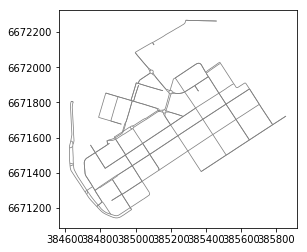

In [452]:
fig, ax = plt.subplots()
edges_proj.plot(ax=ax, linewidth=0.75, color='gray')
plt.show()

In [453]:
graph.graph

{'name': 'Kamppi, Helsinki, Finland',
 'crs': {'init': 'epsg:4326'},
 'simplified': True,
 'streets_per_node': {25216594: 4,
  25238874: 4,
  25238944: 3,
  25291537: 4,
  25291564: 4,
  25291565: 4,
  25291591: 4,
  25292473: 4,
  25416262: 4,
  25416263: 3,
  25416267: 3,
  56113314: 4,
  56115897: 3,
  56116937: 4,
  57743854: 1,
  60004721: 4,
  60069401: 3,
  60070287: 3,
  60072524: 3,
  60170470: 3,
  60170471: 4,
  60278325: 3,
  103062861: 3,
  148875335: 1,
  149030035: 3,
  149030036: 3,
  149030037: 1,
  149143065: 3,
  150983569: 3,
  159619609: 4,
  175832743: 3,
  232165213: 1,
  258188404: 4,
  258189020: 3,
  266159806: 4,
  266159814: 3,
  266159899: 3,
  267117317: 3,
  267117319: 3,
  268177652: 3,
  282730717: 3,
  282730727: 3,
  282730739: 3,
  282730959: 3,
  282730985: 3,
  282731082: 3,
  295322365: 3,
  301360197: 3,
  313937382: 3,
  313963185: 3,
  314929251: 3,
  315285583: 3,
  317703609: 2,
  319604907: 3,
  319885318: 3,
  319896278: 3,
  337264937: 3,


In [454]:
place_name_out = place_name.replace(' ', '_').replace(',','')
nodes_out = r"shapefiles/%s_nodes.shp" % place_name_out
streets_out = r"shapefiles/%s_streets.shp" % place_name_out

invalid_cols = ['lanes', 'maxspeed', 'name', 'oneway', 'osmid']
for col in invalid_cols:
    edges_proj[col] = edges_proj[col].astype(str)
edges_proj.to_file(streets_out)
nodes_proj.to_file(nodes_out)

/home/jann/Desktop/repos/env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


In [455]:
nodes_proj.loc[1372425714]

highway                                             NaN
lat                                              24.921
lon                                             60.1644
osmid                                        1372425714
x                                                384624
y                                           6.67154e+06
geometry    POINT (384624.1787626689 6671539.986316172)
Name: 1372425714, dtype: object

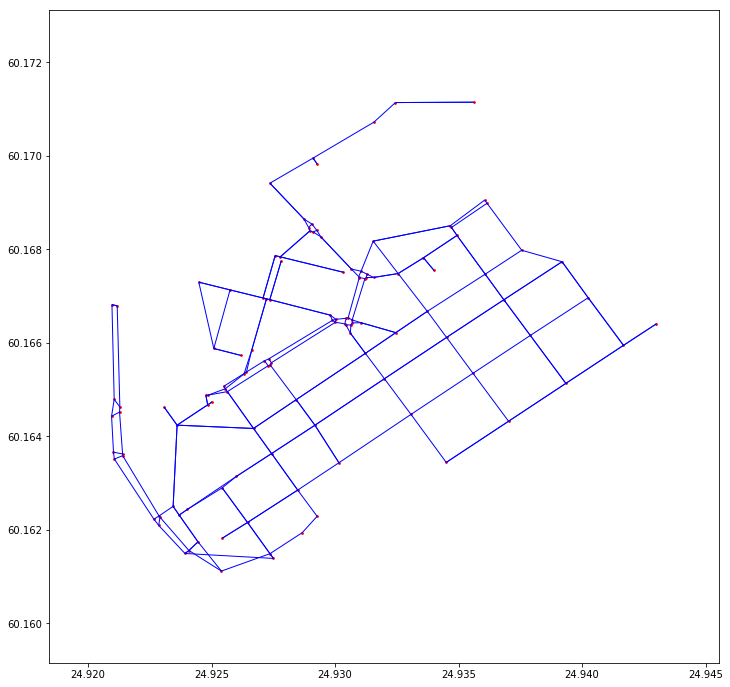

In [456]:
from matplotlib.collections import LineCollection


def draw_graph(G, fig_width, fig_height, bgcolor='w',
               use_geom=False, edge_color='b', edge_linewidth=1,
               edge_alpha=1, node_size=3, node_color='r', node_alpha=1,
               node_edgecolor='r', node_zorder=1):

    fig, ax = plt.subplots(figsize=(fig_width, fig_height), facecolor=bgcolor)
    lines = []
    for u, v, data in G.edges(data=True):
        if 'geometry' in data and use_geom:
            # if it has a geometry attribute (a list of line segments), add them
            # to the list of lines to plot
            xs, ys = data['geometry'].xy
            lines.append(list(zip(xs, ys)))
        else:
            # if it doesn't have a geometry attribute, the edge is a straight
            # line from node to node
            x1 = G.nodes[u]['x']
            y1 = G.nodes[u]['y']
            x2 = G.nodes[v]['x']
            y2 = G.nodes[v]['y']
            line = [(x1, y1), (x2, y2)]
            lines.append(line)

    # add the lines to the axis as a linecollection
    lc = LineCollection(lines, colors=edge_color, linewidths=edge_linewidth, alpha=edge_alpha, zorder=2)
    ax.add_collection(lc)

    node_Xs = [float(x) for _, x in G.nodes(data='x')]
    node_Ys = [float(y) for _, y in G.nodes(data='y')]
    ax.scatter(node_Xs, node_Ys, s=node_size, c=node_color, alpha=node_alpha, edgecolor=node_edgecolor, zorder=node_zorder)

    plt.show()
    

bgcolor = 'w'
use_geom = False
edge_color = 'b'
edge_linewidth = 1
edge_alpha = 1

node_size = 3
node_color = 'r'
node_alpha = 1
node_edgecolor = 'r'
node_zorder = 1
draw_graph(graph, 12, 12)